In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T

In [3]:
learning_rate = 1e-4
nepochs = 20
batch_size = 32
max_len = 128
data_set_root = "."

In [4]:
dataset_train = AG_NEWS(root=data_set_root, split="train")  # Training dataset
dataset_test = AG_NEWS(root=data_set_root, split="test")  # Test dataset

In [5]:
# Here, we use the `get_tokenizer` function from the `torchtext.data.utils` module to create a tokenizer based on the "basic_english" tokenization method.
tokenizer = get_tokenizer("basic_english")

# Define a generator function `yield_tokens` to yield tokens from the data iterator.
# The data iterator provides pairs of (label, text) where text is the input sentence.
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Build the vocabulary from the tokens yielded by the `yield_tokens` generator function.
# We set `min_freq=2` to include a token only if it appears more than 2 times in the dataset.

# We will also add "special" tokens that we'll use to signal something to our model
    # <pad> is a padding token that is added to the end of a sentence to ensure the length of all sequences in a batch is the same
    # <sos> signals the "Start-Of-Sentence" aka the start of the sequence
    # <eos> signal the "End-Of-Sentence" aka the end of the sequence
    # <unk> "unknown" token is used if a token is not contained in the vocab

vocab = build_vocab_from_iterator(
    yield_tokens(dataset_train),  # Tokenized data generator, that takes in the dataset
    min_freq = 2,  # Minimum frequency threshold for token inclusion
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],  # Special case tokens
    special_first = True  # Place special tokens first in the vocabulary
)

# Set the default index of the vocabulary to the index of the '<unk>' token.
# If a token is not found in the vocabulary, it will be replaced with the '<unk>' token.
vocab.set_default_index(vocab['<unk>'])

In [6]:
# Lets have a look at the vocab!
vocab.get_itos()

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 '.',
 'the',
 ',',
 'to',
 'a',
 'of',
 'in',
 'and',
 's',
 'on',
 'for',
 '#39',
 '(',
 ')',
 '-',
 "'",
 'that',
 'with',
 'as',
 'at',
 'is',
 'its',
 'new',
 'by',
 'it',
 'said',
 'reuters',
 'has',
 'from',
 'an',
 'ap',
 'his',
 'will',
 'after',
 'was',
 'us',
 'be',
 'over',
 'have',
 'their',
 '&lt',
 'are',
 'up',
 'quot',
 'but',
 'more',
 'first',
 'two',
 'he',
 'world',
 'u',
 'this',
 '--',
 'company',
 'monday',
 'wednesday',
 'tuesday',
 'oil',
 'out',
 'thursday',
 'one',
 'not',
 'against',
 'inc',
 'friday',
 'into',
 'they',
 'about',
 'last',
 'iraq',
 'year',
 'than',
 'york',
 'yesterday',
 'who',
 'president',
 'microsoft',
 'no',
 'were',
 '?',
 'been',
 'million',
 't',
 'says',
 'week',
 'had',
 'corp',
 'united',
 'game',
 'when',
 'sunday',
 'prices',
 'could',
 'three',
 'would',
 'today',
 'years',
 'group',
 'security',
 'government',
 'time',
 'people',
 'which',
 'may',
 'afp',
 'percent',
 'software',
 '1',


In [7]:
label, text = next(iter(dataset_train))

# Print the original text
print("Original Text:")
print(text)

# Tokenize the text using the tokenizer
print("\nTokenized Text:")
print(tokenizer(text))

Original Text:
Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.

Tokenized Text:
['wall', 'st', '.', 'bears', 'claw', 'back', 'into', 'the', 'black', '(', 'reuters', ')', 'reuters', '-', 'short-sellers', ',', 'wall', 'street', "'", 's', 'dwindling\\band', 'of', 'ultra-cynics', ',', 'are', 'seeing', 'green', 'again', '.']


In [13]:
# Define a text transformation pipeline using torchtext Sequential transform
text_transform = T.Sequential(
    # Convert the sentences to indices based on the given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> at the beginning of each sentence. 1 is used because the index for <sos> in the vocabulary is 1
    T.AddToken(1, begin=True),
    # Crop the sentence if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    # Add <eos> at the end of each sentence. 2 is used because the index for <eos> in the vocabulary is 2
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor. This also pads a sentence with the <pad> token if it is shorter than the max length, ensuring that all sentences are the same length
    T.ToTensor(padding_value=0)
)

In [14]:
# Define a lambda function for tokenizing each batch of text data
text_tokenizer = lambda batch: [tokenizer(x) for x in batch]

# Create data loaders for training and testing
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last = True)

In [25]:
class LSTM(nn.Module):
    def __init__(self, num_emb, output_size, num_layers=1, hidden_size=128):
        super(LSTM, self).__init__()
        
        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size) # (vocab_size, hidden_size). -> (B, T, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.5)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_in, mem_in):
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq) # (B ,T) -> (B, T, hidden_size)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))

        # (B, T, hidden_size), (4, B, hidden_size), (4, B, hidden_size)
                
        # Pass the LSTM output through the fully connected layer to get the final output
        return self.fc_out(output), hidden_out, mem_out
        # (B, T, output_size)

In [26]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

hidden_size = 64

num_layers = 2

lstm_classifier = LSTM(num_emb=len(vocab), output_size=4, num_layers=num_layers, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam optimizer
optimizer = optim.Adam(lstm_classifier.parameters(), lr=learning_rate)

# Define the loss function as CrossEntropyLoss for classification
loss_fn = nn.CrossEntropyLoss()

# Initialize lists to store training and test loss, as well as accuracy
training_loss_logger = []
test_loss_logger = []
training_acc_logger = []
test_acc_logger = []

In [30]:
train_acc = 0

test_acc = 0

# Loop through each epoch
for epoch in range(nepochs):
    
    # Set model to training mode
    lstm_classifier.train()
    steps = 0
    
    # Iterate through training data loader
    for label, text in data_loader_train:
        
        bs = label.shape[0]

        # Notice here, that we have to tokenize the text before transforming it
        # text is a tuple of strings. Using our lambda function, we tokenize each string using list comprehension
        text_tokens = text_transform(text_tokenizer(text)).to(device)
        label = (label - 1).to(device) # Normalize to array indices (CrossEntropy expects array indices)
        
        # Initialize hidden and memory states
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device) # (4, bs, hidden_size)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device) # (4, bs, hidden_size)
        
        # Forward pass through the model
        pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

        # Calculate the loss (taking the last time step)
        loss = loss_fn(pred[:, -1, :], label) # (bs, output_size) & (bs)
            
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append training loss to logger
        training_loss_logger.append(loss.item())
        
        # Calculate training accuracy
        train_acc += (pred[:, -1, :].argmax(1) == label).sum()
        steps += bs
        
    # Calculate and append training accuracy for the epoch
    train_acc = (train_acc/steps).item()
    training_acc_logger.append(train_acc)
    
    # Set model to evaluation mode
    lstm_classifier.eval()
    steps = 0
    
    # Iterate through test data loader
    with torch.no_grad():
        for label, text in data_loader_test:
            bs = label.shape[0]
            # Tokenize and transform text to tensor, move to device
            text_tokens = text_transform(text_tokenizer(text)).to(device)
            label = (label - 1).to(device)

            # Initialize hidden and memory states
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            
            # Forward pass through the model
            pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            # Calculate test accuracy
            test_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs

        # Calculate and append test accuracy for the epoch
        test_acc = (test_acc/steps).item()
        test_acc_logger.append(test_acc)

    print(f"loss: {loss.item()}")

loss: 1.4050706624984741


KeyboardInterrupt: 

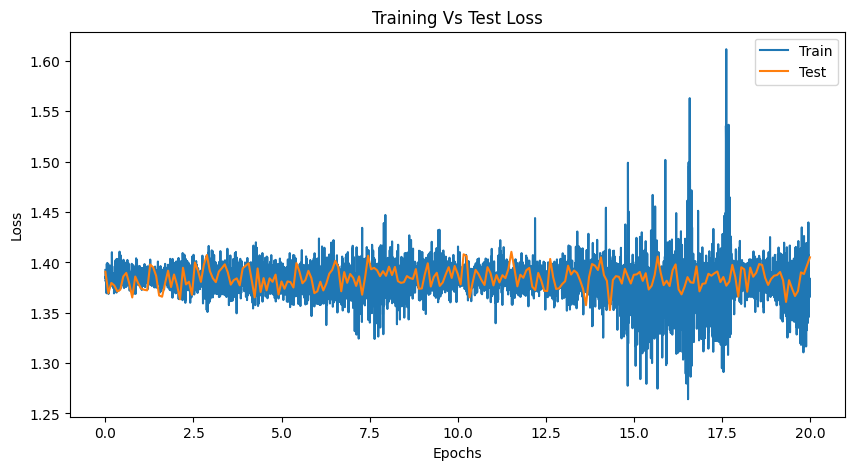

In [31]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

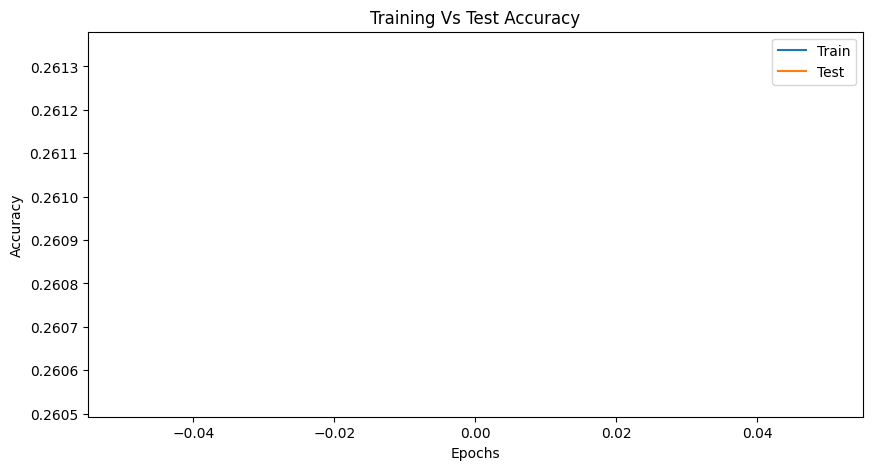

In [32]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")